In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, pickle
import datetime as dt

# initialize a connection to the database
import sqlite3
conn = sqlite3.connect('../Spotify_Challenge/dbsql.db')

# initialize another sqlalchemy connection to the same database to be able to query data straight to pandas dataframe
from sqlalchemy import create_engine
disk_engine = create_engine('sqlite:///../Spotify_Challenge/dbsql.db')

from sklearn.preprocessing import Imputer#,StandardScaler, RobustScaler
from sklearn.cluster import KMeans

In [2]:
features = [u'index',u'YEAR', u'QUARTER', u'MONTH', u'DAY_OF_MONTH', u'DAY_OF_WEEK', u'AIRLINE_ID', 
            u'CARRIER', u'TAIL_NUM', u'FL_NUM', u'ORIGIN_AIRPORT_ID', u'ORIGIN', u'ORIGIN_CITY_NAME', 
            u'ORIGIN_STATE_NM', u'DEST_AIRPORT_ID', u'DEST', u'DEST_CITY_NAME', u'DEST_STATE_NM', 
            u'DEP_DELAY', u'DEP_DELAY_NEW', u'DEP_DEL15', u'TAXI_OUT', u'TAXI_IN', u'ARR_DELAY', 
            u'ARR_DELAY_NEW', u'ARR_DEL15', u'CANCELLED', u'CANCELLATION_CODE', u'DIVERTED', u'AIR_TIME', 
            u'FLIGHTS', u'DISTANCE', u'CARRIER_DELAY', u'WEATHER_DELAY', u'NAS_DELAY', u'SECURITY_DELAY', 
            u'LATE_AIRCRAFT_DELAY',u'FL_DATE']
years = (2010,2011,2012,2013,2014,2015)

In [261]:
# load airports data. This is the table containing coordinates of airports
airports = pd.read_sql_query('select iata, lat, long from airports',disk_engine)


# load all data aggregated by origin
tic = dt.datetime.now() #time the process
if 'agg_per_origin' in map(lambda x:x[0],conn.execute("select name from sqlite_master where type = 'table'").fetchall()):
    # load the table if it exists already
    df1 = pd.read_sql_query("SELECT * FROM agg_per_origin",disk_engine)
    if 'index' in df1.columns:
        df1.drop('index',axis=1,inplace=True)
else:
    # otherwise, query data from the database
    print "querying from raw data"
    df1 = pd.read_sql_query("SELECT YEAR, ORIGIN, SUM(FLIGHTS) AS FLIGHTS, SUM(DEP_DEL15) AS DEP_DEL, "
                            "SUM(DEP_DELAY) AS DDEL1, SUM(DEP_DELAY_NEW) AS DDEL2, SUM(CANCELLED) AS CANCELLED, "
                            "SUM(SECURITY_DELAY) AS SEC_DEL, SUM(CARRIER_DELAY) AS CAR_DEL, SUM(NAS_DELAY) AS NAS_DEL, "
                            "SUM(WEATHER_DELAY) AS WEA_DEL, SUM(LATE_AIRCRAFT_DELAY) AS LAD_DEL "
                            "FROM data "
                            "GROUP BY YEAR, ORIGIN",disk_engine)
    #push the aggregated data back to the database
    df1.to_sql('agg_per_origin',conn,index=False)
print dt.datetime.now()-tic #print the time taken for this operation


# load all data aggreagated by destination
tic = dt.datetime.now() #time the process
if 'agg_per_destination' in map(lambda x:x[0],conn.execute("select name from sqlite_master where type = 'table'").fetchall()):
    # load the table if it exists already
    df2 = pd.read_sql_query("SELECT * FROM agg_per_destination",disk_engine)
    if 'index' in df2.columns:
        df2.drop('index',axis=1,inplace=True)
else:
    # otherwise, query data from the database
    print "querying from raw data"
    df2 = pd.read_sql_query("SELECT YEAR, DEST, SUM(FLIGHTS) AS FLIGHTS, SUM(ARR_DEL15) AS ARR_DEL, "
                            "SUM(ARR_DELAY) AS ADEL1, SUM(ARR_DELAY_NEW) AS ADEL2, SUM(DIVERTED) AS DIVERTED "
                            "FROM data "
                            "GROUP BY YEAR, DEST",disk_engine)
    #push the aggregated data back to the database
    df2.to_sql('agg_per_destination',conn,index=False)
print dt.datetime.now()-tic #print the time taken for this operation


# put origin and destination data together
#loop through years and merge data in df1, df2 and airports per year and origin
tmp_df = pd.DataFrame()
for yoi in years:
    agg_df = pd.merge(df1[df1.YEAR == yoi],df2[df2.YEAR == yoi],left_on='ORIGIN',right_on='DEST')

    # append coordinates as well
    agg_df = pd.merge(agg_df,airports,left_on='ORIGIN', right_on='iata')
    agg_df.drop(['DEST','YEAR_y','iata'],axis=1,inplace=True)
    agg_df.rename(columns={'YEAR_x':'YEAR','FLIGHTS_x':'DEP_FLIGHTS','FLIGHTS_y':'ARR_FLIGHTS','ORIGIN':'IATA',
                           'lat':'LAT','long':'LON'}, inplace=True)

    # assign aggregated data to airports
    tmp_df = pd.concat([tmp_df,agg_df],ignore_index=True)

# now let's normalize some features with respect to the number of departure flights 
#features_to_normalize = ['DEP_FLIGHTS','DEP_DEL','DDEL1','DDEL2','CANCELLED','SEC_DEL','CAR_DEL','NAS_DEL',
#                         'WEA_DEL','LAD_DEL','ARR_FLIGHTS','ARR_DEL','ADEL1','ADEL2','DIVERTED']
#airports = tmp_df[['YEAR','IATA']]
#for col in features_to_normalize:
#    airports[col] = (tmp_df.loc[:,col]/tmp_df['DEP_FLIGHTS']).values
airports_all = tmp_df.copy()
airports = airports_all[(airports_all.YEAR >= 2010)|(airports_all.YEAR <= 2015)]
airports = airports.groupby('IATA').mean().reset_index()

0:00:00.014914
0:00:00.013103


### Feature Engineering

Let's create a new feature, **RECOVERED_TIME**, which is the difference between delay time at arrival and delay time at departure

In [262]:
airports_all['RECOVERED_TIME'] = airports_all.ARR_DEL - airports_all.DEP_DEL
airports['RECOVERED_TIME'] = airports.ARR_DEL - airports.DEP_DEL

### Correlations between numric features
- Without normalization, the correlations between features range between 0.48 and 1. ->This is a big correlation
- Upon normalization with respect to the number of departing flights, the correlations decrease to -0.15 to 1 -> better

In [263]:
categorical_features = airports.columns[:2].tolist()
numeric_features = airports.columns[2:-3].tolist()+[u'RECOVERED_TIME']
#numeric_features.append('RECOVERED_TIME')
coord_features = airports.columns[-3:-1].tolist()

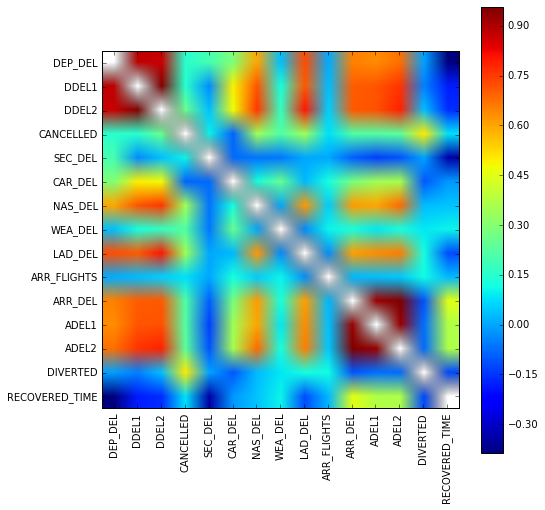

In [264]:
fig,ax = plt.subplots(1,1,figsize = [8,8])
#corr_mat = airports[numeric_features].corr()
airports_norm = pd.DataFrame((airports[numeric_features[1:]].values.transpose()/airports['DEP_FLIGHTS'].values).transpose(),
                             columns=numeric_features[1:])
corr_mat = airports_norm.corr()
plt.imshow(corr_mat.replace(1,np.NaN)) # plot corr_mat after hiding correlations of a feature with itself
plt.xticks(range(corr_mat.shape[0]),corr_mat.columns,rotation = 'vertical')
plt.yticks(range(corr_mat.shape[0]),corr_mat.columns)
plt.colorbar()
plt.savefig('corr_airports_norm.eps',format='eps')
plt.show()

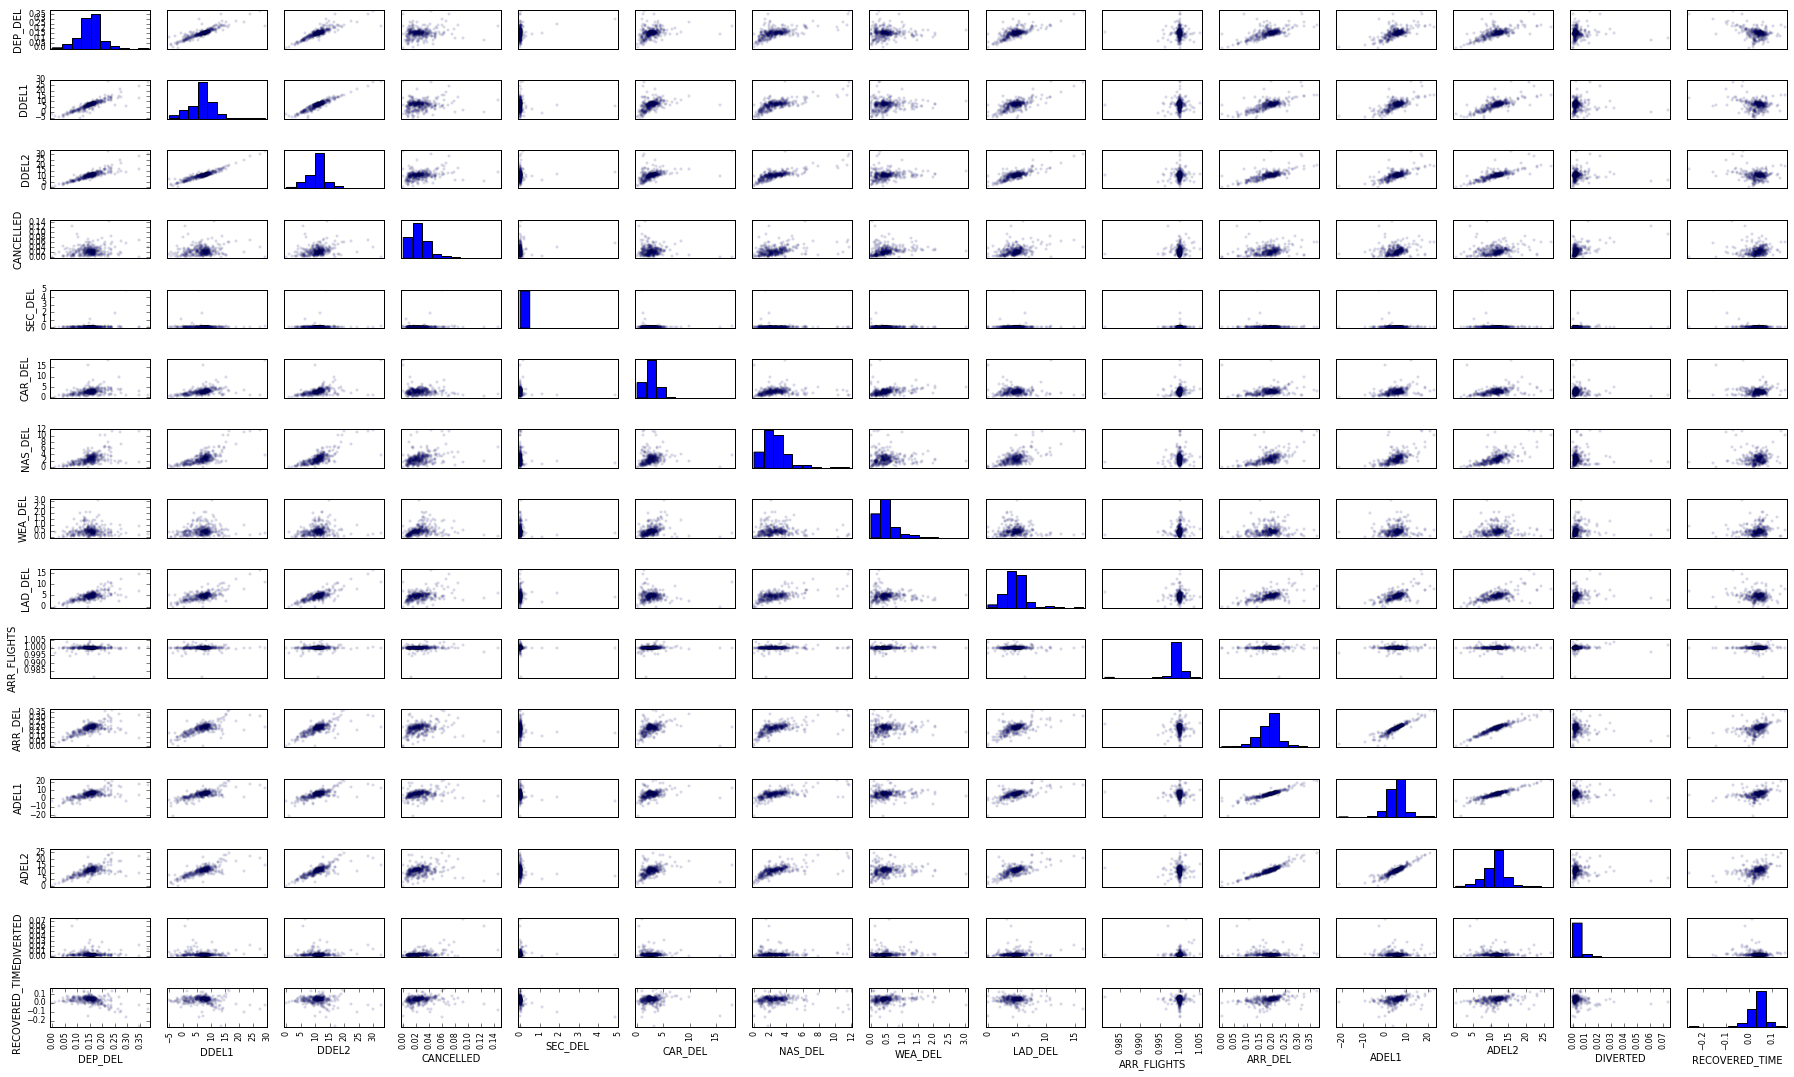

In [265]:
fig,ax = plt.subplots(1,1,figsize = [25,15])
pd.tools.plotting.scatter_matrix(airports_norm, alpha=0.1,ax=ax)
plt.tight_layout()

After careful analysis of the correlation charts, following features are not highly correlated to others:
    - Uncorrelated: ARR_FLIGHTS, CANCELLED, DIVERTED, SEC_DEL, WEA_DEL, CAR_DEL, NAS_DEL, ARR_DEL, RECOVERED_TIME
    - Slightly correlated: DEP_DEL, LAD_DEL

### Search for clusters

Here we shall use identified features above, to look for possible clusters in the airports data

In [266]:
# remove NaN
imputer = Imputer(strategy='most_frequent')
airports_norm[airports_norm.columns] = imputer.fit_transform(airports_norm)

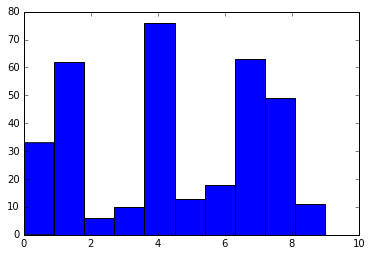

In [271]:
K = 10
kmeans_1 = KMeans(K)
kmeans_1.fit(airports_norm[['ARR_FLIGHTS','CANCELLED','DIVERTED','WEA_DEL','NAS_DEL','RECOVERED_TIME']])
centroids = kmeans_1.cluster_centers_
labels = kmeans_1.labels_

plt.hist(labels,bins=K)
plt.show()

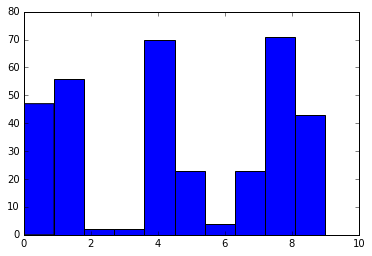

In [273]:
K = 10
kmeans_2 = KMeans(K)
kmeans_2.fit(airports_norm[['CAR_DEL','ARR_DEL','DEP_DEL']])
centroids = kmeans_2.cluster_centers_
labels = kmeans_2.labels_

plt.hist(labels,bins=K)
plt.show()

After different optimization trials (initial number of clusters and feature selection), we come up with two ways of clusterization:
1. Use **ARR_FLIGHTS, CANCELLED, DIVERTED, WEA_DEL, NAS_DEL and ,RECOVERED_TIME** with initial number of clusters **$K=10$**.
2. Use ** CAR_DEL, ARR_DEL and DEP_DEL** with initial number of clusters **$K=10$**.

Next, we clusterize aiports by geo-location using LAT and LON

In [337]:
K = 6
kmeans_3 = KMeans(K)
df = airports[['LAT','LON']]
kmeans_3.fit(df)
centroids = kmeans_3.cluster_centers_
labels = kmeans_3.labels_
df['GEO_CLASS'] = labels


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel-4.0.3-py2.7.egg/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


With an attempt to split airports in 6 groups, we end up with one group being made by one airport. Since 150 is closer to -170 in Longitude than it would be to -70, this point is joined to group 6.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel-4.0.3-py2.7.egg/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


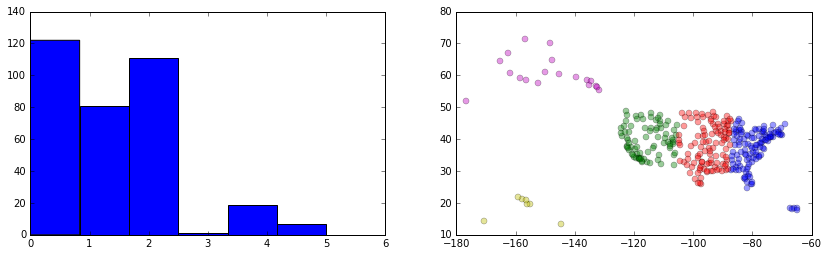

In [338]:
df['GEO_CLASS'] = df.GEO_CLASS.replace(3,6)
fig,axs = plt.subplots(1,2,figsize = [14,4])
axs[0].hist(labels,bins=K)
for kk in range(K):
    axs[1].plot(df[df.GEO_CLASS == kk]['LON'],df[df.GEO_CLASS == kk]['LAT'],'o',alpha = 0.4)
plt.show()


Let's save the two models to disk and then define one function that predict the cluster of an input

In [340]:
# comment out the following block after retraining above models

#with open('airports_cluster_model_1.pkl','w') as f:
#    pickle.dump(kmeans_1,f)
#    f.close()
#with open('airports_cluster_model_2.pkl','w') as f:
#    pickle.dump(kmeans_2,f)
#    f.close()
#with open('airports_cluster_model_3.pkl','w') as f:
#    pickle.dump(kmeans_3,f)
#    f.close()
#with open('airports_imputer.pkl','w') as f:
#    pickle.dump(imputer,f)
#    f.close()

In [341]:
def classify_airport(data):
    """
    data should be normalized with respoct to DEP_FLIGHTS first
    
    """
    with open('airports_cluster_model_1.pkl','r') as f:
        #use criterion 1
        ac_mdl1 = pickle.load(f)
        f.close()
    with open('airports_cluster_model_2.pkl','r') as f:
        #use criterion 2
        ac_mdl2 = pickle.load(f)
        f.close()
    with open('airports_cluster_model_3.pkl','r') as f:
        #use geo coordinates
        ac_mdl3 = pickle.load(f)
        f.close()
    with open('airports_imputer.pkl','r') as f:
        a_imputer = pickle.load(f)
        f.close()
    features_1 = ['ARR_FLIGHTS','CANCELLED','DIVERTED','WEA_DEL','NAS_DEL','RECOVERED_TIME']
    features_2 = ['CAR_DEL','ARR_DEL','DEP_DEL']
        

array([6, 9, 4, 4, 8, 7, 4, 7, 7, 4, 1, 8, 6, 1, 3, 5, 8, 4, 1, 5, 5, 8, 6,
       8, 6, 6, 3, 3, 1, 3, 8, 3, 8, 4, 8, 1, 8, 3, 8, 8, 6, 6, 6, 4, 8, 8,
       4, 1, 3, 0, 6, 4, 8, 3, 6, 6, 1, 1, 2, 3, 3, 6, 7, 6, 9, 4, 6, 8, 6,
       6, 5, 0, 1, 8, 3, 5, 8, 4, 6, 8, 6, 5, 9, 3, 4, 6, 5, 6, 3, 3, 3, 5,
       8, 6, 8, 1, 6, 3, 8, 0, 3, 1, 3, 4, 0, 9, 0, 6, 4, 6, 4, 1, 6, 3, 8,
       4, 4, 6, 0, 8, 2, 6, 4, 6, 8, 9, 4, 4, 8, 4, 8, 3, 6, 9, 4, 6, 6, 6,
       8, 4, 8, 3, 8, 3, 1, 4, 1, 9, 4, 6, 4, 3, 1, 2, 8, 6, 6, 3, 3, 4, 7,
       8, 9, 3, 4, 4, 5, 4, 8, 1, 1, 3, 3, 3, 5, 9, 4, 4, 1, 1, 6, 3, 8, 9,
       8, 4, 7, 4, 6, 3, 6, 8, 1, 3, 7, 6, 8, 3, 3, 1, 3, 4, 6, 8, 3, 3, 8,
       3, 8, 4, 7, 3, 3, 3, 3, 6, 0, 3, 6, 8, 7, 3, 0, 3, 6, 6, 3, 8, 3, 8,
       8, 2, 1, 3, 8, 1, 1, 8, 3, 1, 4, 5, 3, 6, 2, 1, 1, 0, 6, 8, 3, 6, 6,
       4, 6, 8, 6, 1, 3, 9, 8, 6, 8, 4, 1, 3, 6, 3, 0, 3, 0, 8, 6, 6, 8, 6,
       8, 8, 6, 0, 9, 6, 3, 3, 8, 4, 6, 0, 3, 0, 4, 0, 6, 8, 8, 6, 1, 4, 8,
       9, 1,

In [255]:
df = airports_norm.head()
kmeans_2.predict(df[['CAR_DEL','ARR_DEL','DEP_DEL']])

array([5, 1, 3, 3, 5], dtype=int32)

In [254]:
df

NameError: name 'df' is not defined

In [ ]:
Girabawe